In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

In [2]:
dt = pd.read_csv('twitter_training.csv', names=['ID', 'Topic', 'Sentiment', 'Tweet'], header=None)
dt.head(10)

,ID,Topic,Sentiment,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
5,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
6,2402,Borderlands,Positive,So I spent a few hours making something for fu...
7,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
8,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
9,2402,Borderlands,Positive,So I spent a few hours making something for fu...


In [3]:
dt.tail(10)

,ID,Topic,Sentiment,Tweet
74672,9199,Nvidia,Positive,Let no elite go unnoticed... NVIDIA Highlights...
74673,9199,Nvidia,Positive,Let no elim go unnoticed.... NVIDIA Highlights...
74674,9199,Nvidia,Positive,Let a no information elim that go unnoticed......
74675,9199,Nvidia,Positive,<unk> my elim be no.... NVIDIA Highlights Pict...
74676,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...
74681,9200,Nvidia,Positive,Just like the windows partition of my Mac is l...


In [4]:
dt.columns

Index(['ID', 'Topic', 'Sentiment', 'Tweet'], dtype='object')

In [5]:
dt.index

RangeIndex(start=0, stop=74682, step=1)

In [6]:
dt.shape

(74682, 4)

In [7]:
dt.size

298728

In [8]:
dt.describe()

,ID
count,74682.000000
mean,6432.586165
std,3740.427870
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [9]:
dt.isna().sum()

,0
ID,0
Topic,0
Sentiment,0
Tweet,686


In [10]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   Topic      74682 non-null  object
 2   Sentiment  74682 non-null  object
 3   Tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [11]:
# Define a function to handle non-string values
def analyze_sentiment(text):
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    else:
        return 0.0

In [12]:
# Perform sentiment analysis
dt['Polarity'] = dt['Tweet'].apply(analyze_sentiment)

# Categorize sentiment
dt['Sentiment_Label'] = dt['Polarity'].apply(lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral')

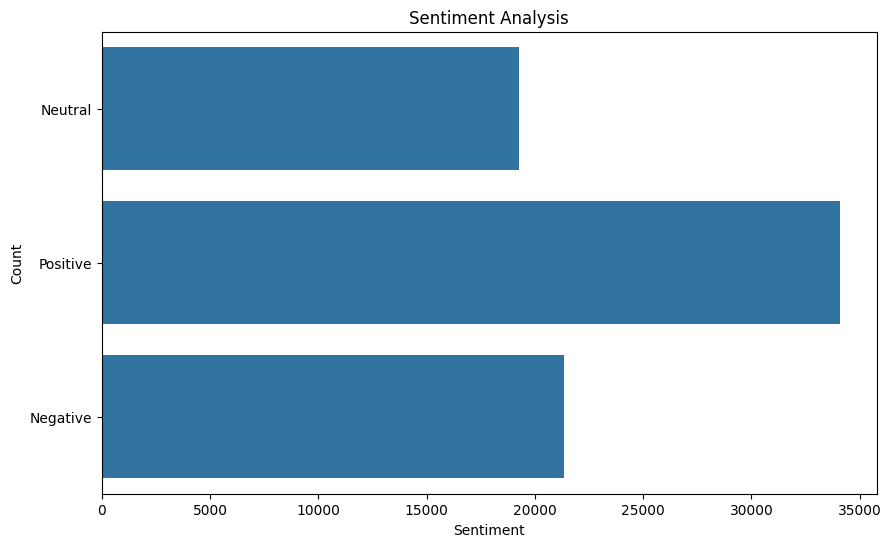

In [13]:
# Analyze sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(dt['Sentiment_Label'])
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

<Figure size 1500x800 with 0 Axes>

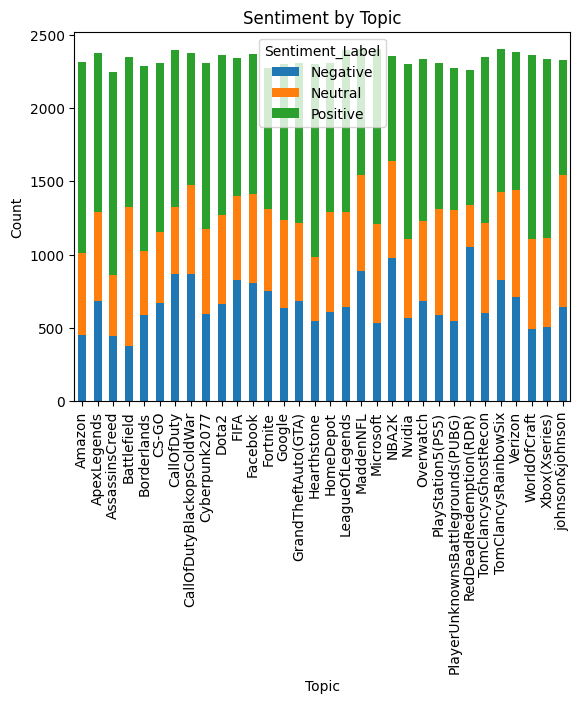

In [14]:
# Analyze sentiment by topic
plt.figure(figsize=(15,8))
sentiment_by_topic = dt.groupby(['Topic', 'Sentiment_Label']).size().unstack(fill_value=0)
sentiment_by_topic.plot(kind='bar', stacked=True)
plt.title('Sentiment by Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()

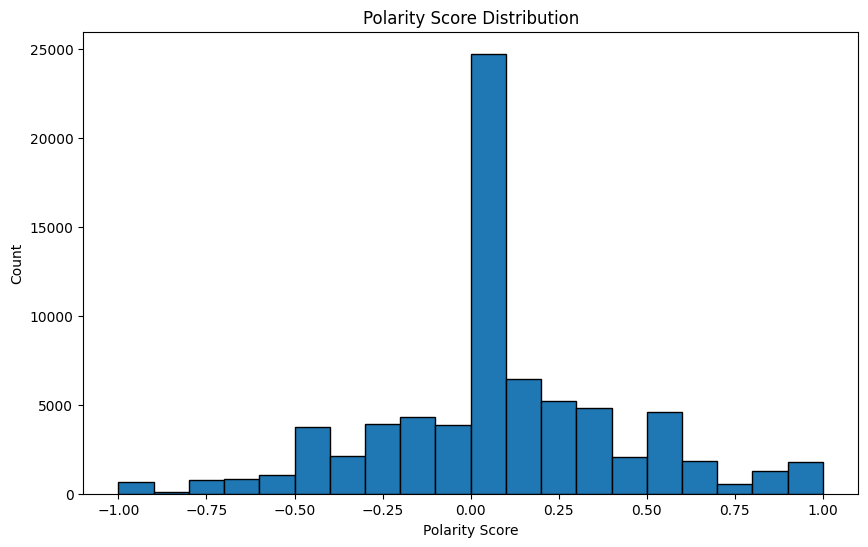

In [15]:
plt.figure(figsize=(10, 6))
plt.hist(dt['Polarity'], bins=20, edgecolor='k')
plt.title('Polarity Score Distribution')
plt.xlabel('Polarity Score')
plt.ylabel('Count')
plt.show()

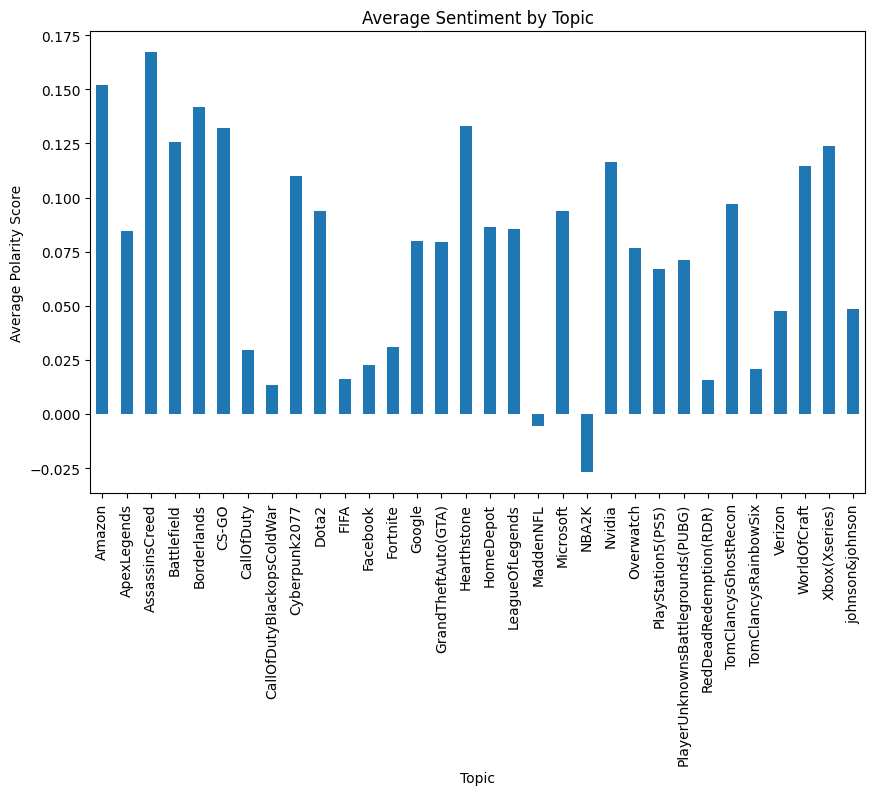

In [16]:
plt.figure(figsize=(10, 6))
average_polarity_by_topic = dt.groupby('Topic')['Polarity'].mean()
average_polarity_by_topic.plot(kind='bar')
plt.title('Average Sentiment by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Polarity Score')
plt.show()

In [17]:
# Visualize the most positive and negative tweets
most_positive_tweet = dt[dt['Polarity'] == dt['Polarity'].max()]['Tweet'].values[0]
most_negative_tweet = dt[dt['Polarity'] == dt['Polarity'].min()]['Tweet'].values[0]

print('Most Positive Tweet:')
print(most_positive_tweet)

print('\nMost Negative Tweet:')
print(most_negative_tweet)

Most Positive Tweet:
Platinum is the best loot @Borderlands  

Most Negative Tweet:
"What terrible bitch!"


In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Preprocess the tweets
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

def preprocess_text(text):
    # Handle potential float values
    if isinstance(text, float):
        return ''
    tokens = tokenizer.tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

dt['Processed_Tweet'] = dt['Tweet'].apply(preprocess_text)

# Vectorize the preprocessed tweets
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(dt['Processed_Tweet'])




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# Apply LDA topic modeling
num_topics = 5  # Adjust the number of topics as needed
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf)

# Print the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

print("LDA Topics:")
print_top_words(lda, vectorizer.get_feature_names_out(), 10)

# Apply NMF topic modeling
nmf = NMF(n_components=num_topics, random_state=42)
nmf.fit(tfidf)

print("\nNMF Topics:")
print_top_words(nmf, vectorizer.get_feature_names_out(), 10)

LDA Topics:
Topic #1:
johnson player wow com ban best battlefield nice game baby

Topic #2:
dead red game com redemption playstation creed pic fifa twitter

Topic #3:
wtf shit game like com rhandlerr pic twitter tv twitch

Topic #4:
com good facebook fucking pic time twitter nvidia damn league

Topic #5:
unk love game fuck wait fun really amazon play home


NMF Topics:
Topic #1:
game good like shit fuck play really fucking time best

Topic #2:
unk wow wtf johnson playstation verizon com happy home pubg

Topic #3:
com pic twitter rhandlerr player ban johnson battlefield bf4db facebook

Topic #4:
love new world warcraft guys playing god borderlands people games

Topic #5:
dead red redemption tv redeeming twitch rockstargames games online story



In [24]:
# using text blob algorithm

from textblob import TextBlob

# Function to get sentiment
def get_sentiment(text):
    # Handle potential float values
    if isinstance(text, float):
        return 0.0
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to the 'Tweet' column
dt['Sentiment'] = dt['Tweet'].apply(get_sentiment)

# Categorize sentiment
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

dt['Sentiment_Category'] = dt['Sentiment'].apply(categorize_sentiment)

# Print the sentiment analysis results
dt[['Tweet', 'Sentiment', 'Sentiment_Category']]


,Tweet,Sentiment,Sentiment_Category
0,im getting on borderlands and i will murder yo...,0.00,Neutral
1,I am coming to the borders and I will kill you...,0.00,Neutral
2,im getting on borderlands and i will kill you ...,0.00,Neutral
3,im coming on borderlands and i will murder you...,0.00,Neutral
4,im getting on borderlands 2 and i will murder ...,0.00,Neutral
...,...,...,...
74677,Just realized that the Windows partition of my...,-0.40,Negative
74678,Just realized that my Mac window partition is ...,-0.40,Negative
74679,Just realized the windows partition of my Mac ...,-0.40,Negative
74680,Just realized between the windows partition of...,-0.05,Negative


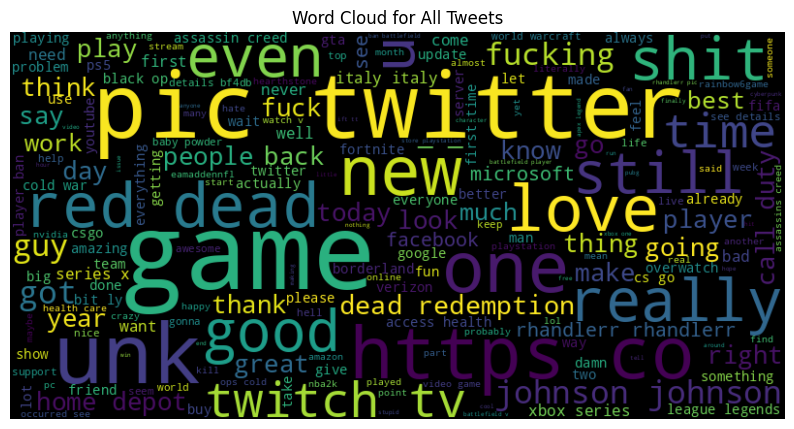

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a word cloud for the entire dataset
all_words = ' '.join(dt['Processed_Tweet'])
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for All Tweets')
plt.show()


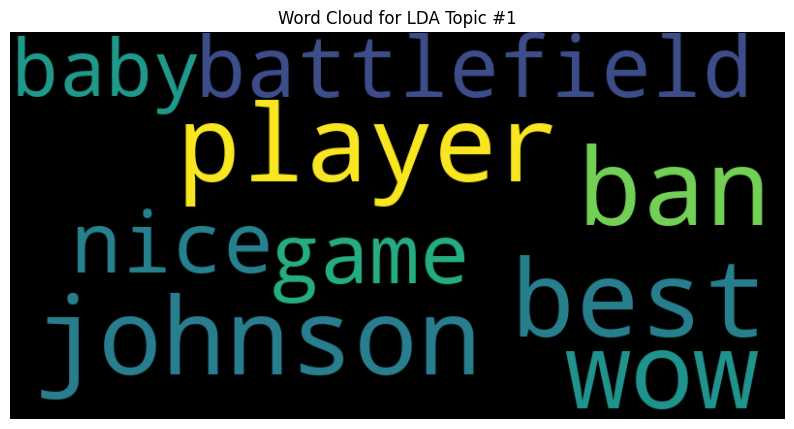

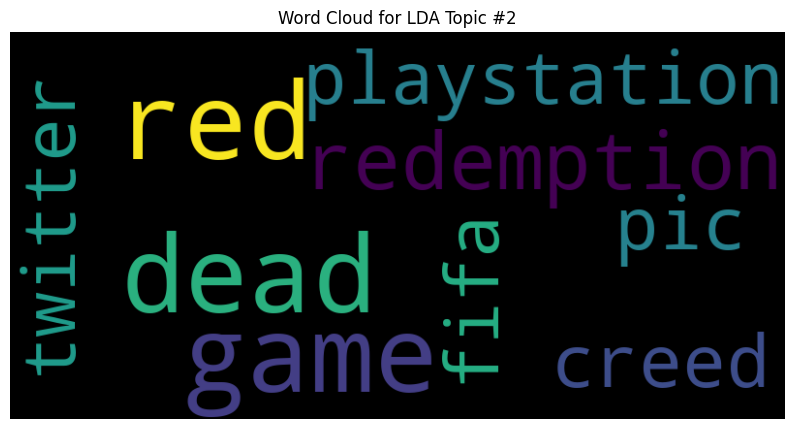

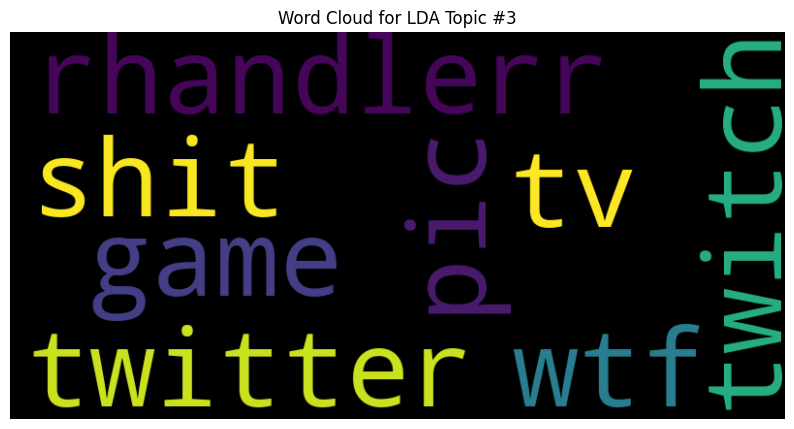

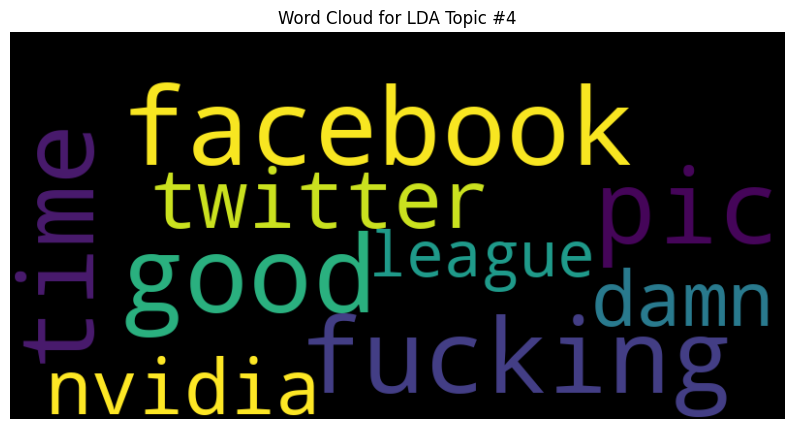

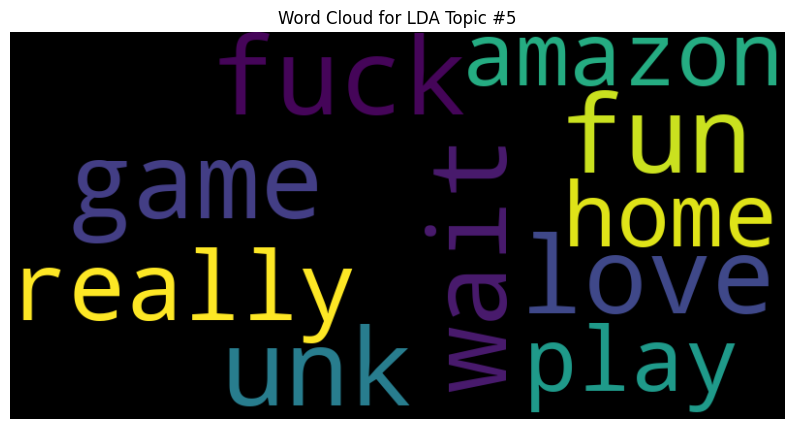

In [28]:
# Create word clouds for each topic (LDA)
for topic_idx, topic in enumerate(lda.components_):
    top_words = " ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]])
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(top_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f'Word Cloud for LDA Topic #{topic_idx + 1}')
    plt.show()

In [ ]:
# My data has no likes and retweet folder
# Assuming I have a DataFrame 'dt' with columns like 'User', 'Followers', 'Retweets', 'Likes':

# Calculate an influence score
dt['Influence_Score'] = dt['Followers'] + dt['Retweets'] * 2 + dt['Likes']

# Sort users by influence score
top_influencers = dt.sort_values('Influence_Score', ascending=False)

# Print the top influencers
print(top_influencers[['User', 'Influence_Score']].head(10))
